# 1. Load test data including 2D positions and yaw.

In [ ]:
import csv
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd


def read_csv_file(path, file):
    if not os.path.exists(path):
        print(f'File {path} does not exist')
        return None
    full_path = os.path.join(path, file + '.csv')

    print(full_path)
    print(f"loading {full_path}")

        # Optional: Check file exists
    if not os.path.isfile(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")
    
    # Read and return the DataFrame
    return pd.read_csv(full_path, low_memory=False)

In [ ]:
# load data
in_path = 'processed/all/robot_group_csv/Group8/'   
person = 'processed_t11'
# in_path = 'data_utils/human_group_csv/Group8'
# person = '1'
data = read_csv_file(in_path, person)
df = pd.DataFrame(data)

processed/all/robot_group_csv/Group8/processed_t11.csv
loading processed/all/robot_group_csv/Group8/processed_t11.csv


In [ ]:
# 3D plot of all coordinates
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['p1_Chest_PX'], df['p1_Chest_PY'], df['p1_Chest_PZ'], label='p1_Chest')
ax.plot(df['p4_Chest_PX'], df['p4_Chest_PY'], df['p4_Chest_PZ'], label='p4_Chest')
ax.plot(df['p2_Chest_PX'], df['p2_Chest_PY'], df['p2_Chest_PZ'], label='p2_Chest')
ax.plot(df['Rigid Body 3_PX'], df['Rigid Body 3_PY'], df['Rigid Body 3_PZ'], label='Rigid Body 3')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Chest and Rigid Body Coordinates')
ax.legend()

plt.tight_layout()
plt.show()

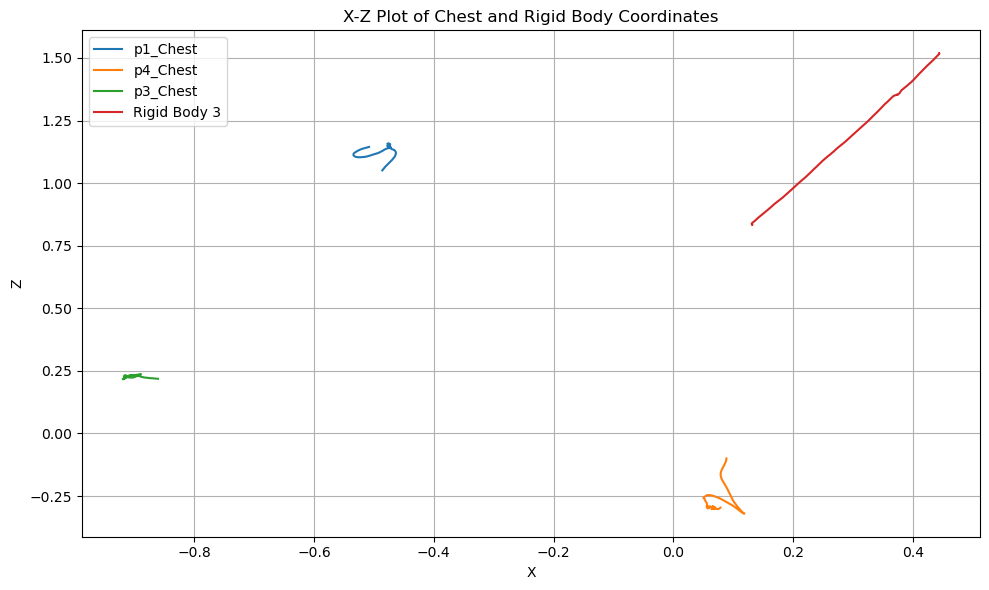

In [43]:
# 2D plot of X vs Z coordinates
plt.figure(figsize=(10, 6))

plt.plot(df['p4_Chest_PX'], df['p4_Chest_PZ'], label='p1_Chest')
plt.plot(df['p2_Chest_PX'], df['p2_Chest_PZ'], label='p4_Chest')
plt.plot(df['p3_Chest_PX'], df['p3_Chest_PZ'], label='p3_Chest')
plt.plot(df['Rigid Body 3_PX'], df['Rigid Body 3_PZ'], label='Rigid Body 3')

plt.xlabel('X')
plt.ylabel('Z')
plt.title('X-Z Plot of Chest and Rigid Body Coordinates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# Parameter of the SN
mu = np.array([ 0.0170915, -0.3079768])
shape = np.array([[ 0.0791303,  -0.01143162],
 [-0.01143162,  0.29992035]])
lmbda = np.array([-0.01057365,  2.15069084])

# Define standard 2D orientation (pointing up in Y direction)
std_orientation = np.array([0, 1])


# Function to transform parameters
def transform_params(position, quaternion, mu, shape, lmbda):

    # Convert quaternion to 3D rotation matrix and extract 2D X-Z submatrix
    rotation_matrix_3d = R.from_quat(quaternion).as_matrix()
    rotation_matrix_2d = rotation_matrix_3d[np.ix_([0, 2], [0, 2])]

    # Apply rotation and translation
    rotated_orientation = rotation_matrix_2d @ std_orientation
    transformed_mu = rotation_matrix_2d @ mu + position
    transformed_shape = rotation_matrix_2d @ shape @ rotation_matrix_2d.T
    transformed_lmbda = rotation_matrix_2d @ lmbda

    return rotated_orientation, transformed_mu, transformed_shape, transformed_lmbda


In [45]:
# Extract 2D position and quaternion from p1

p1_position = np.array([df.iloc[-1][df.columns[0]], df.iloc[-1][df.columns[2]]])
p1_quaternion = np.array([df.iloc[-1][df.columns[3]], df.iloc[-1][df.columns[4]], df.iloc[-1][df.columns[5]], df.iloc[-1][df.columns[6]]])
p2_position = np.array([df.iloc[-1][df.columns[7]], df.iloc[-1][df.columns[9]]])
p2_quaternion = np.array([df.iloc[-1][df.columns[10]], df.iloc[-1][df.columns[11]], df.iloc[-1][df.columns[12]], df.iloc[-1][df.columns[13]]])
p3_position = np.array([df.iloc[-1][df.columns[14]], df.iloc[-1][df.columns[16]]])
p3_quaternion = np.array([df.iloc[-1][df.columns[17]], df.iloc[-1][df.columns[18]], df.iloc[-1][df.columns[19]], df.iloc[-1][df.columns[20]]])

In [46]:
_, p1_mu, p1_shape, p1_lmbda = transform_params(p1_position, p1_quaternion, mu, shape, lmbda)
_, p2_mu, p2_shape, p2_lmbda = transform_params(p2_position, p2_quaternion, mu, shape, lmbda)
_, p3_mu, p3_shape, p3_lmbda = transform_params(p3_position, p3_quaternion, mu, shape, lmbda)

# 2. Applying the learned proxemic model and plotting.

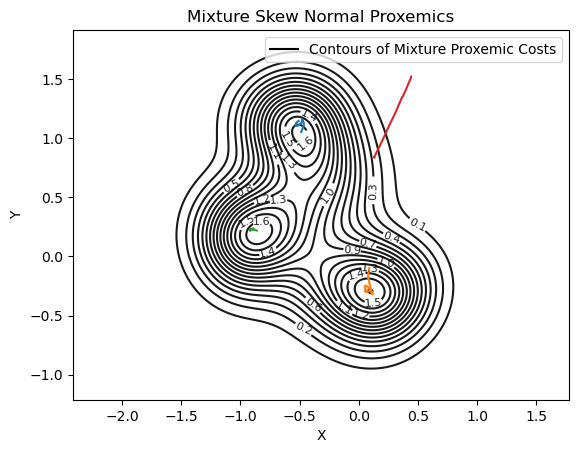

<Figure size 1000x600 with 0 Axes>

In [48]:
from mvem.stats import multivariate_skewnorm as mvsn

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- Generate random samples from three multivariate skew-normal distributions
params = [
    (p1_mu, p1_shape, p1_lmbda),
    (p2_mu, p2_shape, p2_lmbda),
    (p3_mu, p3_shape, p3_lmbda)
]

samples = [mvsn.rvs(mu, shape, lmbda, size=1000) for mu, shape, lmbda in params]

# --- Determine the plotting bounds from all samples
all_samples = np.vstack(samples)
x_min, x_max = np.min(all_samples[:, 0]), np.max(all_samples[:, 0])
y_min, y_max = np.min(all_samples[:, 1]), np.max(all_samples[:, 1])

# --- Define the evaluation grid
X, Y = np.meshgrid(np.linspace(x_min, x_max, 400),
                   np.linspace(y_min, y_max, 400))
pos = np.dstack((X, Y))

# --- Compute PDFs over the grid
pdfs = [mvsn.pdf(pos, mu, shape, lmbda) for mu, shape, lmbda in params]
Z_combined = np.sum(pdfs, axis=0)

# --- Plot combined PDF contours
ticks = MaxNLocator(nbins=19).tick_values(Z_combined.min(), Z_combined.max())
contours = plt.contour(X, Y, Z_combined, levels=ticks, colors='k', alpha=0.9)
plt.clabel(contours, inline=1, fontsize=8)
plt.plot(df['p4_Chest_PX'], df['p4_Chest_PZ'], label='Person 1')
plt.plot(df['p2_Chest_PX'], df['p2_Chest_PZ'], label='Person 2')
plt.plot(df['p3_Chest_PX'], df['p3_Chest_PZ'], label='Person 3')
plt.plot(df['Rigid Body 3_PX'], df['Rigid Body 3_PZ'], label='Robot')

plt.title(f'Mixture Skew Normal Proxemics')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')

# Optional legend
handles = [plt.Line2D([], [], color='k', label='Contours of Mixture Proxemic Costs')]
plt.legend(handles=handles)
plt.figure(figsize=(10, 6))

plt.tight_layout()
plt.show()


### Plot with the yaw

In [ ]:
def rot_yaw(quaternion):
    std_orientation = np.array([0, 1])
    p_rot = R.from_quat(quaternion).as_matrix()
    p_rot = p_rot[[0,2],:][:,[0,2]]
    p_orientation = np.dot(p_rot, std_orientation)

    return p_orientation

p1_last_yaw = [df['p4_Chest_RX'].iloc[-1], df['p4_Chest_RY'].iloc[-1], df['p4_Chest_RZ'].iloc[-1], df['p4_Chest_RW'].iloc[-1]]
p2_last_yaw = [df['p3_Chest_RX'].iloc[-1], df['p3_Chest_RY'].iloc[-1], df['p3_Chest_RZ'].iloc[-1], df['p3_Chest_RW'].iloc[-1]]
p3_last_yaw = [df['p2_Chest_RX'].iloc[-1], df['p2_Chest_RY'].iloc[-1], df['p2_Chest_RZ'].iloc[-1], df['p2_Chest_RW'].iloc[-1]]
robot_last_yaw = [df['Rigid Body 3_RX'].iloc[-1], df['Rigid Body 3_RY'].iloc[-1], df['Rigid Body 3_RZ'].iloc[-1], df['Rigid Body 3_RW'].iloc[-1]]
p1_vec = rot_yaw(p1_last_yaw)
p2_vec = rot_yaw(p2_last_yaw)
p3_vec = rot_yaw(p3_last_yaw)
robot_vec = rot_yaw(robot_last_yaw)
scale = 0.05  # Length scaling factor
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red

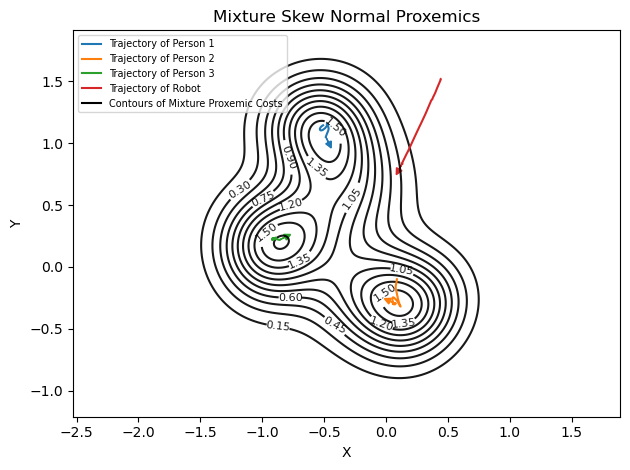

In [ ]:
# Plot the contours
ticks = MaxNLocator(nbins=15).tick_values(Z_combined.min(), Z_combined.max())
contours = plt.contour(X, Y, Z_combined, levels=ticks, colors='k', alpha=0.9)
plt.clabel(contours, inline=True, fontsize=8)

# Plot the tracks with labels
line1, = plt.plot(df['p4_Chest_PX'], df['p4_Chest_PZ'], label='Trajectory of Person 1')
line2, = plt.plot(df['p2_Chest_PX'], df['p2_Chest_PZ'], label='Trajectory of Person 2')
line3, = plt.plot(df['p3_Chest_PX'], df['p3_Chest_PZ'], label='Trajectory of Person 3')
line4, = plt.plot(df['Rigid Body 3_PX'], df['Rigid Body 3_PZ'], label='Trajectory of Robot')

# Example: Arrow pointing from (1, 1) to (2, 2)
plt.arrow(df['p4_Chest_PX'].iloc[-1], df['p4_Chest_PZ'].iloc[-1], p1_vec[0] * scale, p1_vec[1] * scale, width=0.001, head_width=0.05, head_length=0.05, color=colors[0],label='Yaw of Person 1')
plt.arrow(df['p3_Chest_PX'].iloc[-1], df['p3_Chest_PZ'].iloc[-1], p2_vec[0] * scale, p2_vec[1] * scale, width=0.001, head_width=0.05, head_length=0.05, color=colors[2])
plt.arrow(df['p2_Chest_PX'].iloc[-1], df['p2_Chest_PZ'].iloc[-1], p3_vec[0] * scale, p3_vec[1] * scale, width=0.001, head_width=0.05, head_length=0.05, color=colors[1])
plt.arrow(df['Rigid Body 3_PX'].iloc[-1], df['Rigid Body 3_PZ'].iloc[-1], robot_vec[0] * scale, robot_vec[1] * scale, width=0.001, head_width=0.05, head_length=0.05, color=colors[3])

# Create a fake Line2D object for contours
contour_handle = plt.Line2D([], [], color='k', label='Contours of Mixture Proxemic Costs')

# Combine all handles for the legend
plt.legend(handles=[line1, line2, line3, line4, contour_handle], fontsize=7)

plt.title('Mixture Skew Normal Proxemics of Trial 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.tight_layout()

# Save to PNG
plt.savefig("msn_plot_t10.png", dpi=300)

plt.show()
